# Type transformations

Transforming individual geometries: 

- `MultiPoint` to `LineString`
- `MultiPoint` to `Polygon`
- `LineString` to `MultiPoint`
- `Polygon` to `MultiPoint`
- `Polygon`s to `MultiPolygon`
- `MultiPolygon`s to `Polygon`s

Casting workflows on GeoDataFrames
- keep track of attributes
- may dissolve as well as combine
- `MultiLineString` to `LineString` (w/ `explode`)
- `LineString` to `MultiPoint` (w/ `apply`)
- `LineString` to `MultiLineString` (w/ `dissolve`)
- `Polygon`s to `MultiPolygon`(w/ `dissolve` or `agg`)
- `Polygon`s to `(Multi)LineString`s


- multipoint to linestring is commonely used to create lines from ordered point observations allowing spatial operations such as length of path
- multipoint/linestring to polygon often used to calculate an area, eg. a set of GPS measurements taken in a certain area

In [1]:
import shapely 
import geopandas as gpd

## Individual-geometry casting

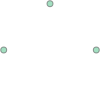

In [2]:
multipoint = shapely.MultiPoint([(1,1), (3,3), (5,1)])
multipoint

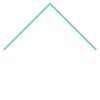

In [3]:
linestring = shapely.LineString(multipoint.geoms)
linestring

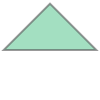

In [5]:
polygon = shapely.Polygon(multipoint.geoms)
polygon

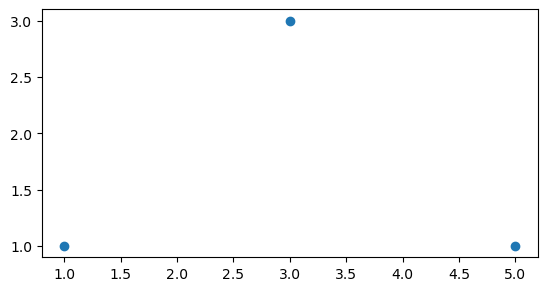

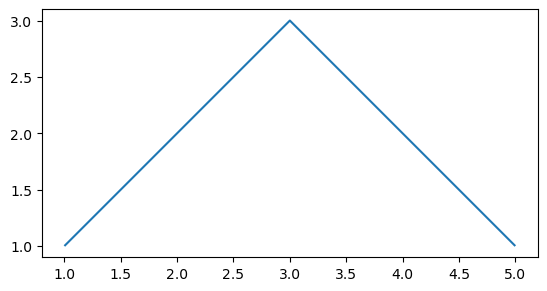

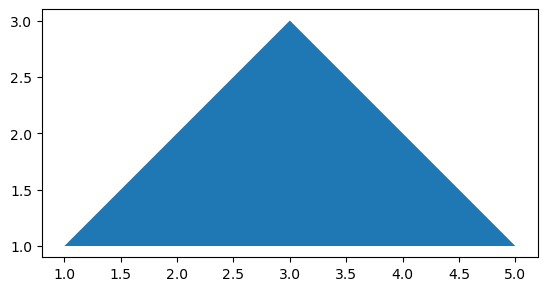

In [7]:
gpd.GeoSeries(multipoint).plot(); 
gpd.GeoSeries(linestring).plot(); 
gpd.GeoSeries(polygon).plot();

>Can convert back

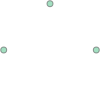

In [8]:
shapely.MultiPoint(linestring.coords)

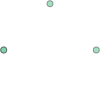

In [9]:
shapely.MultiPoint(polygon.exterior.coords)